# 📊 View as a histogram

In [ ]:
#| default_exp repr_plt

In [ ]:
# |hide
from nbdev.showdoc import *
from fastcore.test import test_eq, is_close

In [ ]:
# |export
# |hide

import math
from typing import Union
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

from lovely_numpy.repr_str import lovely, pretty_str
from lovely_numpy.utils import get_config

In [ ]:
# |hide
matplotlib.rcParams["svg.hashsalt"] = "1"
%config InlineBackend.print_figure_kwargs = {'metadata': {"Date": None, "Creator": "Matplotlib, https://matplotlib.org/" }}

In [ ]:
# |hide
# |exporti
def normal_pdf( x: np.ndarray,
                mean: Union[np.ndarray, float] =0.,
                std: Union[np.ndarray, float] =1.):
    r"""Probability Distribution Function of Normal Distribution:
        $$f(x, \mu, \sigma)
        = \dfrac{1}
            {\sigma \sqrt{2\pi} }
        e^{-\frac{1}{2} \left(\frac{x-\mu}{\sigma}\right)^{2}}
        = \dfrac{e^{- \frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{2}}}
            {\sigma \sqrt{2\pi}}$$"""

    np.e
    # dev = x.device
    
    mean = np.array(mean) #if not isinstance(mean, torch.Tensor) else mean
    std = np.array(std) #.to(dev) if not isinstance(std, torch.Tensor) else std

    return (np.array(np.e) ** ( -0.5 * ((x - mean)/std) ** 2 ) /
                (std * np.sqrt((np.pi * 2)))
            )

In [ ]:
# |hide
# |eval: false

import scipy
x = np.arange(-4, 4, 0.01)
y1 = np.array(scipy.stats.norm.pdf(x, 2, 3))
y2 = normal_pdf(x, 2, 3)

y1, y2
test_eq(is_close(y1, y2), True)

In [ ]:
# |export

def plot(   x: np.ndarray,  # 
            center="zero",        # Center plot on  `zero`, `mean`, or `range`
            max_s=10000,          # Draw up to this many samples. =0 to draw all
            plt0=True,            # Take zero values into account
            ax=None,              # Optionally, supply your own matplotlib axes.
            summary=None           # Summary string (to display on top). None=str(lovely(x))
        ):
    """Plot statistics"""

    assert center in ["zero", "mean", "range"]


    # Mainly useful when you call it from `lovely-tensors`/`-jax` and want to
    # display backend-specific info.
    if summary is None: summary = str(lovely(x, color=False))
    orig_numel = x.size

    assert orig_numel > 0, f"Cannot plot an empty array: {str(lovely(x, color=False))}"

    # `t`` may have nasty things like 'nan' and 'inf'. Could also be of non-float type.
    x = x[ np.isfinite(x) ]

    x_min, x_max = x.min(), x.max()

    # Sometimes we don't want to count zeros in the histogram.
    # Think NN activations after ReLU where half the values are 0.
    if not plt0: x = x[x != 0.]
    
    if x.size > max_s and max_s > 0:
        rng = np.random.default_rng( get_config().plt_seed )
        x = rng.choice(x.reshape(-1), max_s) # Sample with replacement for efficiency

    ### Plot an empty histogram instead of throwing an assert!
    assert x.size > 0, f"Cannot plot array because all values are invalid: {str(lovely(x, color=False))}"
    
    x_mean, x_std = x.mean(), x.std()
   
    t_str = ""
    if x.size != orig_numel:
        t_str += str(x.size) 
        if not plt0: t_str += " non-zero"
        t_str += f" samples (μ={pretty_str(x_mean)}, σ={pretty_str(x_std)}) of "
    t_str += summary

    fig = None
    if not ax:
        fig, ax = plt.subplots(figsize=(12, 2))
        fig.tight_layout()
        plt.close(fig)

    # Center the plot around zero, mean, or the extents of the range of t.
    if center == "range":
        # X limits should center the plot around the mean value
        # x_limit = max(t_min.abs().item(), t_max.abs().item())
        xlim_min, xlim_max = x_min, x_max
    elif center == "mean":
        max_div = max(abs(x_mean - x_min), abs(x_max - x_mean))
        xlim_min, xlim_max = x_mean - max_div, x_mean + max_div
        # x_limits = [t_mean - x_limit, t_mean + x_limit]
    else:
        # X limits should center the plot around zero
        abs_max_value = max(abs(x_min), abs(x_max))
        # ,
                    # (t_mean-max_sigma*t_std).item(), (t_mean+max_sigma*t_std).item())
        xlim_min, xlim_max = -abs_max_value, abs_max_value


    assert x_std != 0, "Std is 0! This is not good. XXX: Handle this"
    assert x_std == x_std, "Std is Nan! This is not good. XXX: Handle this"
        
    sigmas = max(int(math.floor((abs(x_mean - x_min) / x_std))),
                int(math.floor((abs(x_max - x_mean) / x_std))))

    xlim_min -= abs(xlim_max - xlim_min) * 0.02
    xlim_max += abs(xlim_max - xlim_min) * 0.02

    # Around 50 items / bin seems ot look good. But don't go below 10 or above 100.
    bins = int(x.size / 50)
    bins = max(min(bins, 100), 10)

    hvals, hedges = np.histogram(x, range=(xlim_min, xlim_max), bins=bins)

    # histc = x.histc(bins=bins, min=t_min, max=t_max)

    # bar_edges = torch.linspace(t_min, t_max, bins+1)[:bins]
    bar_width = np.diff(hedges[:2]) # bar_edges[:2].diff()

    # Histogram normalized to look like PDF: area under histogram = 1.
    histc_density = (hvals / (hvals.sum() * bar_width))
    ax.bar(x=hedges[:-1], height=histc_density, width=bar_width, color="deepskyblue", align="edge", zorder=4,)


    # PDF of normal distribution with the same mean and std.
    xl = np.linspace(xlim_min, xlim_max, 100)
    normal_density = normal_pdf(xl, mean=x_mean, std=x_std)
    ax.plot(xl, normal_pdf(xl, mean=x_mean, std=x_std), zorder=5)

    y_lim = max(histc_density.max(), normal_density.max()) * 1.3

    # Make text bank part of the line under it
    bbox = dict(boxstyle="round", fc="white", edgecolor="none")

    for s in range(-sigmas, sigmas+1):
        x_pos = (x_mean + s*x_std)
        if xlim_min < x_pos < xlim_max:
            greek = ["-σ", "μ", "+σ"][s+1]  if -1 <= s <= 1 else f"{s:+}σ"
            weight='bold' if not s else None
            ax.axvline(x_pos, 0, 1, c="black")
            ax.text(x_pos, y_lim*0.95, greek, ha="center", va="top", bbox=bbox, zorder=5, weight=weight)

    # 2 red lines for min and max values
    ax.annotate(
        f"min={pretty_str(x_min)}",
        (x_min, y_lim/2),
        xytext=(-1, 0), textcoords='offset points',
        bbox=bbox,
        rotation=90,
        ha="right",
        va="center"
        )

    ax.annotate(
        f"max={pretty_str(x_max)}",
        (x_max, y_lim/2),
        xytext=(2, 0), textcoords='offset points',
        bbox=bbox,
        rotation=90,
        ha="left",
        va="center"
        )

    ax.axvline(x_min, 0, 1, c="red", zorder=4)
    ax.axvline(x_max, 0, 1, c="red", zorder=4)

    ax.text(xlim_min, y_lim*1.05, s=t_str)
    ax.set_ylim(0, y_lim)
    ax.set_yticks([])

    ax.set_xlim(xlim_min, xlim_max )

    return fig

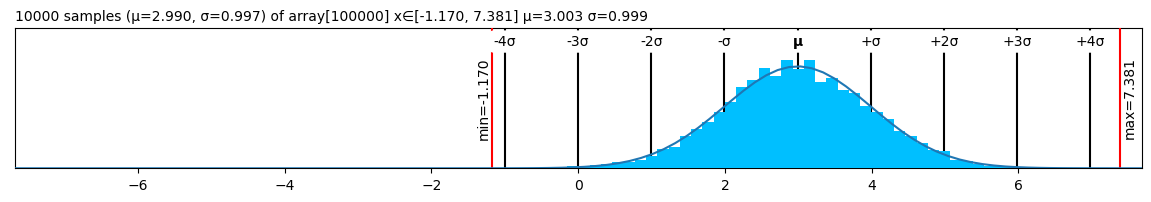

In [ ]:
x = np.random.randn(100000)+3
plot(x)

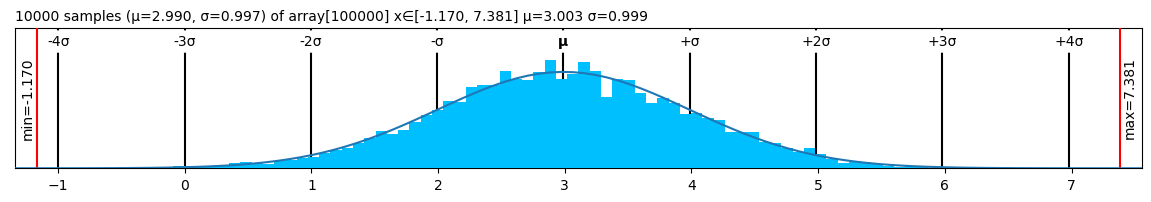

In [ ]:
plot(x, center="range")

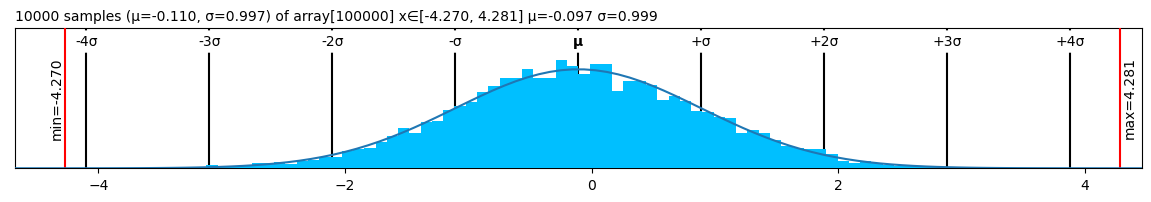

In [ ]:
plot(x-3.1, center="mean")

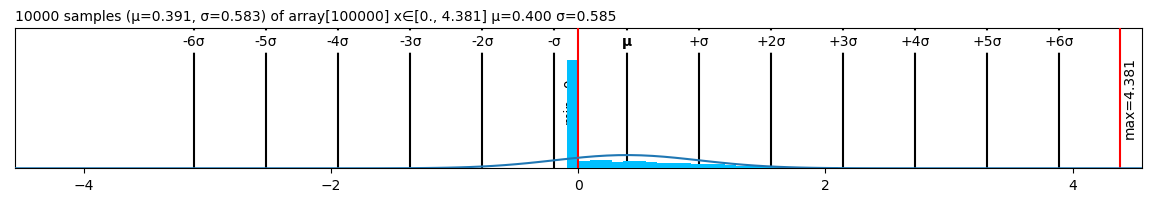

In [ ]:
plot(np.maximum(x-3, 0))

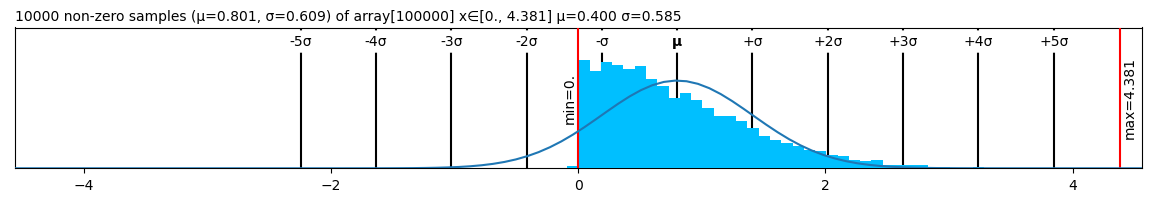

In [ ]:
plot(np.maximum(x-3, 0), plt0=0)

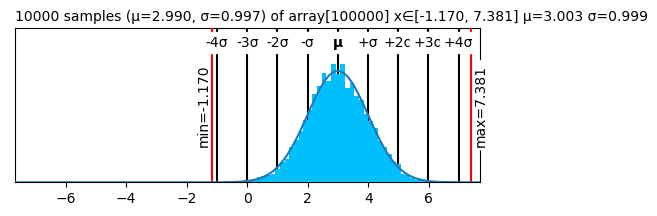

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2))
_ = plot(x, ax=ax)

In [ ]:
# |hide
import nbdev; nbdev.nbdev_export()